In [41]:
import math


class Value:
    def __init__(self, data, _parents = (), _op = ''):
        self._grad_list_ = []
        self.data = data
        self._prev = set(_parents)
        self.grad = 0
        self._op = _op
        self.__update_parent_grad__ = lambda:None
        self.label = ''
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
     
    def backprop(self):
        self.__update_parent_grad__()
        for node in self._prev:
            node.backprop()
            
    def __add__(self, other):
        if type(other) is not Value:
            other = Value(other)
        
        output = Value(self.data + other.data, (self, other), '+')
        
        def __update_parent_grad__():

            self.grad += output.grad
            other.grad += output.grad
            self._grad_list_.append(output.grad)
            other._grad_list_.append(other.grad)

        output.__update_parent_grad__ = __update_parent_grad__
        return output
        
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        if type(other) is not Value:
            other = Value(other)
        output = Value(self.data * other.data, (self, other), '*')
        
        def __update_parent_grad__():
            self_grad_update = other.data * output.grad
            other_grad_update = self.data * output.grad
            self.grad += self_grad_update
            other.grad += other_grad_update
            self._grad_list_.append(self_grad_update)
            other._grad_list_.append(other_grad_update)
            
        output.__update_parent_grad__ = __update_parent_grad__
        return  output
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        if type(other) is not Value:
            return self/Value(other)
        return self * other ** -1
    
    def __rtruediv__(self, other):
        if type(other) is not Value:
            return Value(other)/self
        return other.__truediv__(self)
    
    def __pow__(self, power, modulo=None):
        if type(power) is not Value:
            return self ** Value(power)
        
        output = Value(self.data**power.data, (self, power), '**')
        def __update_parent_grad__():
            self_grad_update = (power.data * self.data ** (power.data-1))*output.grad
            other_grad_update = ((self.data ** power.data) * math.log(self.data))*output.grad
            
            self.grad += self_grad_update
            power.grad += other_grad_update
            self._grad_list_.append({self_grad_update, output.grad})
            power._grad_list_.append({other_grad_update, output.grad})
        output.__update_parent_grad__ = __update_parent_grad__
        return output
        

In [42]:
a = Value(5)
x = Value(-1)
c = a*2
b = a*3

result = (b + c)*(a**x)
result.grad = 1

a.label = 'a'
b.label = 'b'
c.label = 'c'
x.label = 'x'
result.label = 'result'
result.backprop()
result


Value(data=5.0)

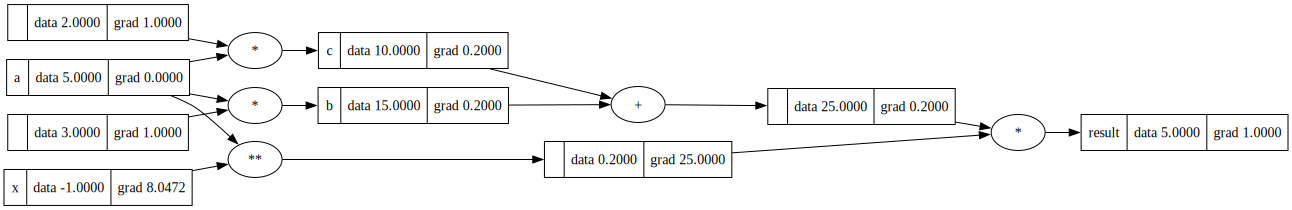

In [43]:
draw_dot(result)

In [44]:
a._grad_list_

[{-1.0, 25}, 0.6000000000000001, 0.4]

In [39]:
result._prev

{Value(data=0.2), Value(data=25)}

In [6]:
a = Value(3)
b = Value(2)
c = 1/b
c.grad = 1
c.backprop()

In [58]:
b.grad

tensor([0.2000], dtype=torch.float64)

In [16]:
b.grad

-0.25

In [17]:
import torch

In [53]:
a = torch.Tensor([5]).double()
a.requires_grad = True

b = a*3
c = a*6
b.retain_grad()
c.retain_grad()
result = (c+b)/a


In [55]:
result.backward()

In [46]:
result

tensor([9.], dtype=torch.float64, grad_fn=<DivBackward0>)

In [57]:
c.grad

tensor([0.2000], dtype=torch.float64)

In [16]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [31]:
numerator, denominator = Value(5), Value(7)
result = numerator/denominator
result.label = 'r'
numerator.label = 'numerator'
denominator.label = 'denominator'
result.grad = 1
result.backprop()

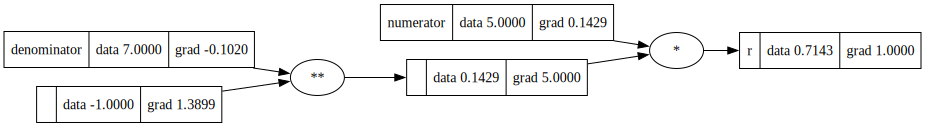

In [32]:
draw_dot(result)

In [34]:
denominator._grad_list_

[-0.1020408163265306]